Wczytywanie danych: 100%|██████████| 200/200 [04:52<00:00,  1.46s/it]





Epoch 1/10


10/10 [==============================] - 149s 14s/step - loss: 0.6421 - accuracy: 0.8389 - val_loss: 0.5227 - val_accuracy: 0.9027
Epoch 2/10
10/10 [==============================] - 129s 13s/step - loss: 0.4622 - accuracy: 0.8510 - val_loss: 0.3027 - val_accuracy: 0.9027
Epoch 3/10
10/10 [==============================] - 130s 13s/step - loss: 0.3592 - accuracy: 0.8510 - val_loss: 0.2495 - val_accuracy: 0.9027
Epoch 4/10
10/10 [==============================] - 114s 11s/step - loss: 0.3062 - accuracy: 0.8510 - val_loss: 0.2043 - val_accuracy: 0.9033
Epoch 5/10
10/10 [==============================] - 111s 11s/step - loss: 0.2558 - accuracy: 0.8746 - val_loss: 0.1480 - val_accuracy: 0.9460
Epoch 6/10
10/10 [==============================] - 119s 12s/step - loss: 0.2286 - accuracy: 0.9023 - val_loss: 0.2052 - val_accuracy: 0.9197
Epoch 7/10
10/10 [==============================] - 145s 15s/step - loss: 0.2203 - accuracy: 0.9019 - val_loss: 0.1203 - val_accuracy: 0.9485
E

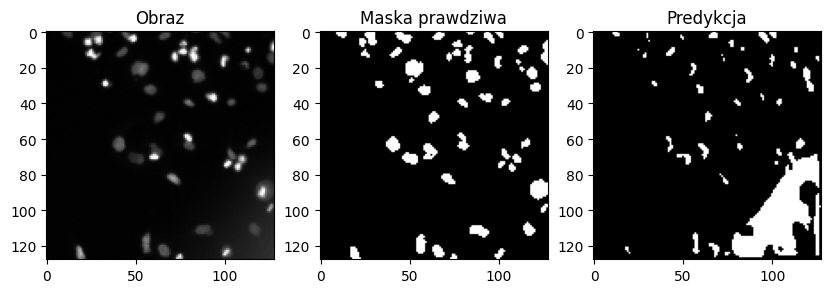

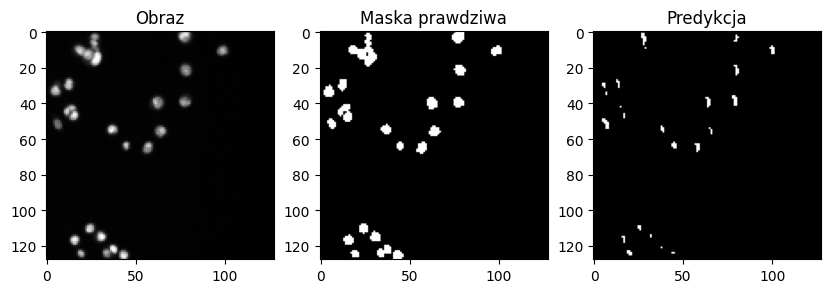

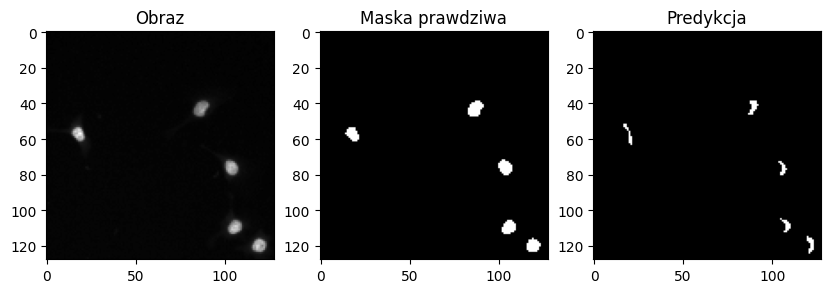

In [ ]:

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

def load_nuclei_data(base_path, img_size=(128, 128), limit=None):
    image_ids = os.listdir(base_path)
    if limit:
        image_ids = image_ids[:limit]

    images = []
    masks = []

    for image_id in tqdm(image_ids, desc="Wczytywanie danych"):
        image_path = os.path.join(base_path, image_id, 'images', image_id + '.png')
        mask_dir = os.path.join(base_path, image_id, 'masks')

        if not os.path.exists(image_path) or not os.path.exists(mask_dir):
            continue

        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        img = img.astype("float32") / 255.0
        images.append(img[..., np.newaxis])

        mask = np.zeros(img_size, dtype=np.float32)
        for mask_file in glob(os.path.join(mask_dir, '*.png')):
            m = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
            m = cv2.resize(m, img_size)
            m = (m > 127).astype(np.float32)
            mask = np.maximum(mask, m)
        masks.append(mask[..., np.newaxis])

    return np.array(images), np.array(masks)


def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        k = tf.random.uniform((), maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k)
        mask = tf.image.rot90(mask, k)
    return image, mask

def prepare_dataset(images, masks, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.map(lambda x, y: augment(x, y))
    dataset = dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    return x

def encoder_block(x, filters):
    f = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(f)
    return f, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(x)
    x = layers.concatenate([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    b1 = conv_block(p3, 512)
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d3)
    return models.Model(inputs, outputs)

base_path = 'stage1_train/stage1_train'  
images, masks = load_nuclei_data(base_path, img_size=(128, 128), limit=200)

x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)
train_dataset = prepare_dataset(x_train, y_train)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(16)

model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, validation_data=val_dataset, epochs=10)

def show_predictions(model, dataset, num=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        for i in range(num):
            plt.figure(figsize=(10, 3))
            plt.subplot(1, 3, 1)
            plt.imshow(images[i, ..., 0], cmap='gray')
            plt.title("Obraz")
            plt.subplot(1, 3, 2)
            plt.imshow(masks[i, ..., 0], cmap='gray')
            plt.title("Maska prawdziwa")
            plt.subplot(1, 3, 3)
            plt.imshow(preds[i, ..., 0] > 0.5, cmap='gray')
            plt.title("Predykcja")
            plt.show()

show_predictions(model, val_dataset)


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def load_test_images(test_dir, img_size=(128, 128)):
    image_ids = os.listdir(test_dir)
    images = []
    original_shapes = []
    ids = []

    for image_id in tqdm(image_ids, desc="Wczytywanie testu"):
        img_path = os.path.join(test_dir, image_id, 'images', image_id + '.png')
        if not os.path.exists(img_path):
            continue
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        original_shapes.append(img.shape[:2])
        img_resized = cv2.resize(img, img_size)
        img_resized = img_resized.astype("float32") / 255.0
        images.append(img_resized[..., np.newaxis])
        ids.append(image_id)
    
    return np.array(images), original_shapes, ids

test_path = 'stage1_test'  
x_test, original_shapes, test_ids = load_test_images(test_path, img_size=(128, 128))

y_test_pred = model.predict(x_test)

output_dir = 'predictions_test'
os.makedirs(output_dir, exist_ok=True)

for i in range(len(test_ids)):
    mask = (y_test_pred[i, ..., 0] > 0.5).astype(np.uint8) * 255
    mask_resized = cv2.resize(mask, (original_shapes[i][1], original_shapes[i][0]))
    out_path = os.path.join(output_dir, test_ids[i] + "_pred.png")
    cv2.imwrite(out_path, mask_resized)

print(f"Zapisano {len(test_ids)} masek do folderu: {output_dir}")


Wczytywanie testu: 100%|██████████| 65/65 [00:03<00:00, 17.08it/s]


3/3 [==============================] - 17s 5s/step
Zapisano 65 masek do folderu: predictions_test
